In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import operator
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pdpbox import pdp
import seaborn as sns
from treeinterpreter import treeinterpreter as ti
from sklearn.metrics import f1_score

sys.path.append("..")
from src.models import model_params

plt.rcParams['figure.figsize'] = 12, 8

In [3]:
def _return_best_trees(X, y, model, num_trees):
    score_dict = {}
    for estimator in model.estimators_:
        y_pred = estimator.predict(X)
        f1 = f1_score(y, y_pred)
        score_dict[estimator] = f1
    return sorted(
        score_dict.items(),
        key=operator.itemgetter(1),
        reverse=True
    )[:num_trees]


def _extract_segment(tree, feature_names):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    impurity = tree.tree_.impurity
    features = feature_names[0]
    value = tree.tree_.value

    def recurse(left, right, threshold, impurity, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            pos_prob = value[node][0][1] / (
                value[node][0][1] + value[node][0][0])
            num_samples = int(value[node].sum())
            if depth == 1:
                print(indent, 'Probability of response: ', pos_prob)
                print(indent, 'Num samples: ', num_samples)
            elif depth > 1:
                print(indent, 'Probability of response: ', pos_prob)
                print(indent, 'Num samples: ', num_samples)
            else:
                print(indent, 'Starting samples: ', num_samples)

            if (value[left[node]][0][0] > value[left[node]][0][1]):
                # go right if the left node represents the 'no response' class
                go_right = True
            elif (value[left[node]][0][1] / value[left[node]].sum()) >= (
                    value[right[node]][0][1] / value[right[node]].sum()):
                # go left if the left node has a higher proportion of
                # 'response' class
                go_right = False
            elif (impurity[left[node]] >= impurity[right[node]]):
                # go right if yields greater reduction in impurity
                go_right = True
            else:
                print('Help, not sure what to do here!')
                return

            if go_right:
                sign = ' >= '
            else:
                sign = ' <= '

            print(
                indent,
                "if ( " + features + sign + str(threshold[node]) + " ) {"
            )

            if go_right and right[node] != -1:
                recurse(
                    left, right, threshold, impurity, features, right[node],
                    depth+1)
            elif left[node] != -1:
                recurse(
                    left, right, threshold, impurity, features, left[node],
                    depth+1)
        else:
            pos_prob = (
                value[node][0][1] / (value[node][0][1] + value[node][0][0]))
            print(
                indent, "return ",
                pos_prob, 'with num_samples = ', int(value[node].sum())
            )

    recurse(left, right, threshold, impurity, features, 0)

In [4]:
df_train = pd.read_csv(
    '../data/final/gambit_sample_train.csv.gz',
    compression='gzip',
    parse_dates=['most_recent_signup', 'most_recent_post'],
    infer_datetime_format=True,
)

In [5]:
X_train = df_train.drop(columns=['target'])
y_train = df_train['target']

In [6]:
df_test = pd.read_csv(
    '../data/final/gambit_sample_test.csv.gz',
    compression='gzip',
    parse_dates=['most_recent_signup', 'most_recent_post'],
    infer_datetime_format=True,
)

X_test = df_test.drop(columns=['target'])
y_test = df_test['target']

In [7]:
model = pickle.load(open('../models/rf-20.pkl', 'rb'))

In [8]:
pipeline = getattr(model_params, 'feature_pipeline')

In [9]:
X_train = pipeline.transform(X_train)

In [10]:
X_test = pipeline.transform(X_test)

In [11]:
import random

noise_ser = [random.random() for i in range(len(X_train))]
X_train['random_col'] = noise_ser

noise_ser_test = [random.random() for i in range(len(X_test))]
X_test['random_col'] = noise_ser_test

In [12]:
for feature in X_train.columns:
    print(feature)
    X_sub = X_train[feature]
    model.fit(pd.DataFrame({feature: X_sub}), y_train.values)
    
    X_test_sub = X_test[feature]
    y_pred = model.predict(pd.DataFrame({feature: X_test_sub}))
    
    print(f1_score(y_test, y_pred))
    tree = _return_best_trees(pd.DataFrame({feature: X_test_sub}), y_test, model, 1)
    _extract_segment(tree[0][0], [feature])
    print('\n')

num_signups
0.787851169997038
 Starting samples:  391948
 if ( num_signups >= 0.5 ) {
   Probability of response:  0.9591263796524351
   Num samples:  149570
   if ( num_signups >= 1.5 ) {
     Probability of response:  0.978884829335713
     Num samples:  70235
     if ( num_signups >= 2.5 ) {
       Probability of response:  0.9848609901172061
       Num samples:  35488
       if ( num_signups >= 4.5 ) {
         Probability of response:  0.9915109774400681
         Num samples:  9697
         if ( num_signups <= 9.5 ) {
           Probability of response:  0.9919190813349119
           Num samples:  9344
           if ( num_signups >= 7.5 ) {
             Probability of response:  0.9961252861668619
             Num samples:  958
             if ( num_signups <= 8.5 ) {
               return  0.9977498591814711 with num_samples =  550


num_rbs
0.21571018651362986
 Starting samples:  391948
 if ( num_rbs >= 0.5 ) {
   Probability of response:  0.9051442958547151
   Num samples:  273

In [13]:
X_train.drop(columns=['random_col'], axis=1, inplace=True)
X_test.drop(columns=['random_col'], axis=1, inplace=True)

In [14]:
model = pickle.load(open('../models/rf-20.pkl', 'rb'))

In [15]:
len(X_test.columns)

29

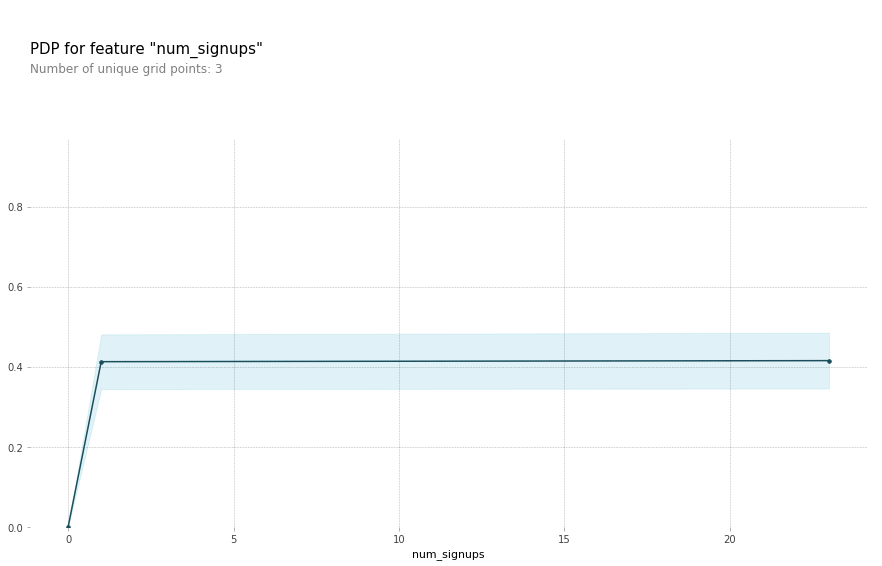

In [16]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(model=model, dataset=X_test, model_features=X_test.columns, feature=feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=False,
                        cluster=clusters is not None, 
                        n_cluster_centers=clusters)

plot_pdp(feat='num_signups');

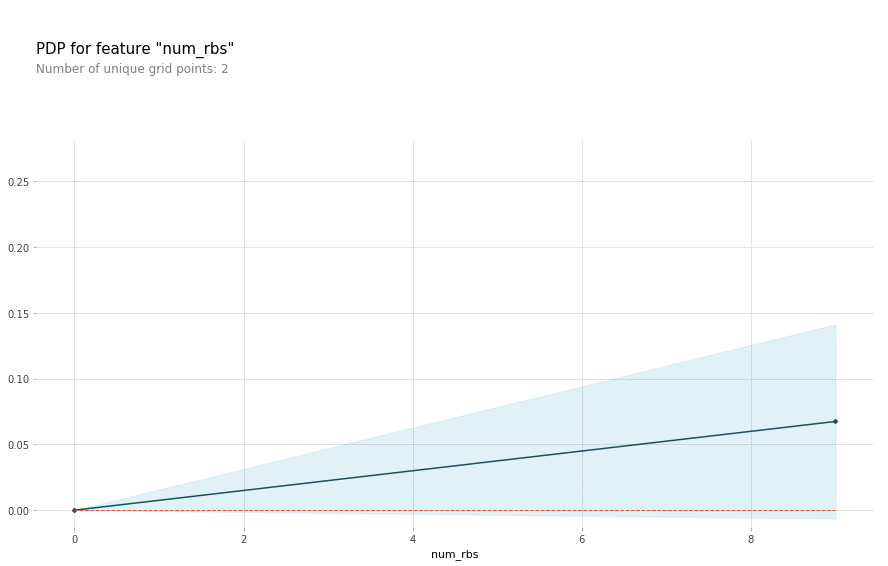

In [17]:
plot_pdp(feat='num_rbs');

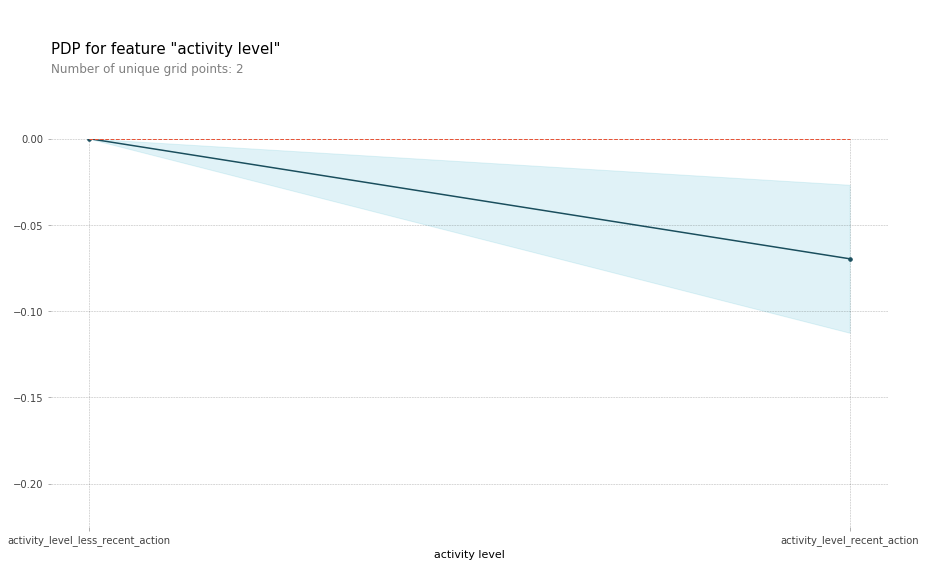

In [18]:
plot_pdp(feat=['activity_level_less_recent_action', 'activity_level_recent_action'], feat_name='activity level');

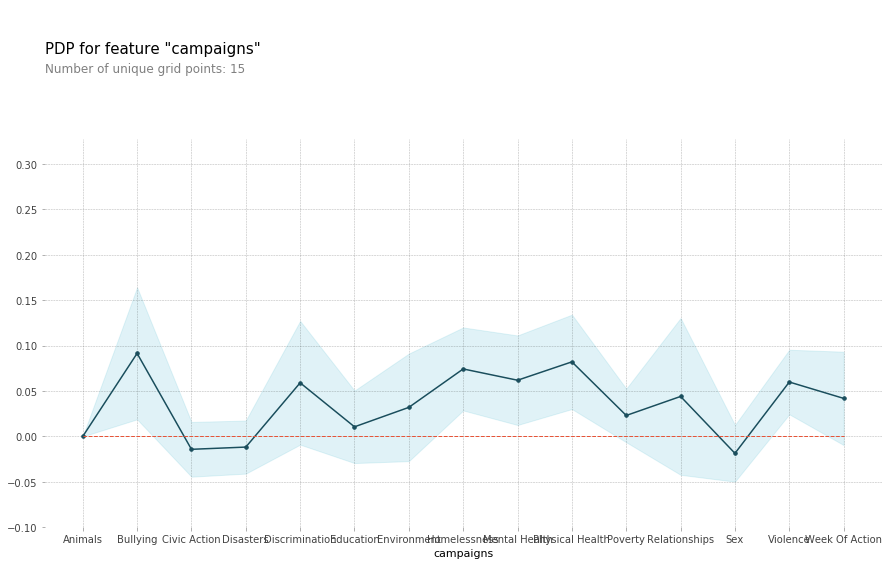

In [19]:
plot_pdp(feat=['Animals',
       'Bullying', 'Civic Action', 'Disasters', 'Discrimination', 'Education',
       'Environment', 'Homelessness', 'Mental Health', 'Physical Health',
       'Poverty', 'Relationships', 'Sex', 'Violence', 'Week Of Action',], feat_name='campaigns');

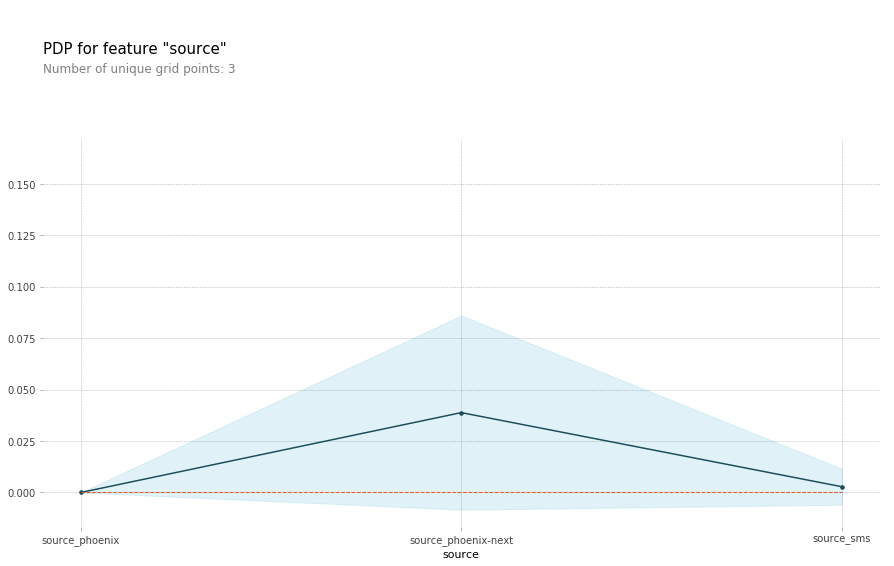

In [20]:
plot_pdp(feat=['source_phoenix', 'source_phoenix-next', 'source_sms'], feat_name='source');

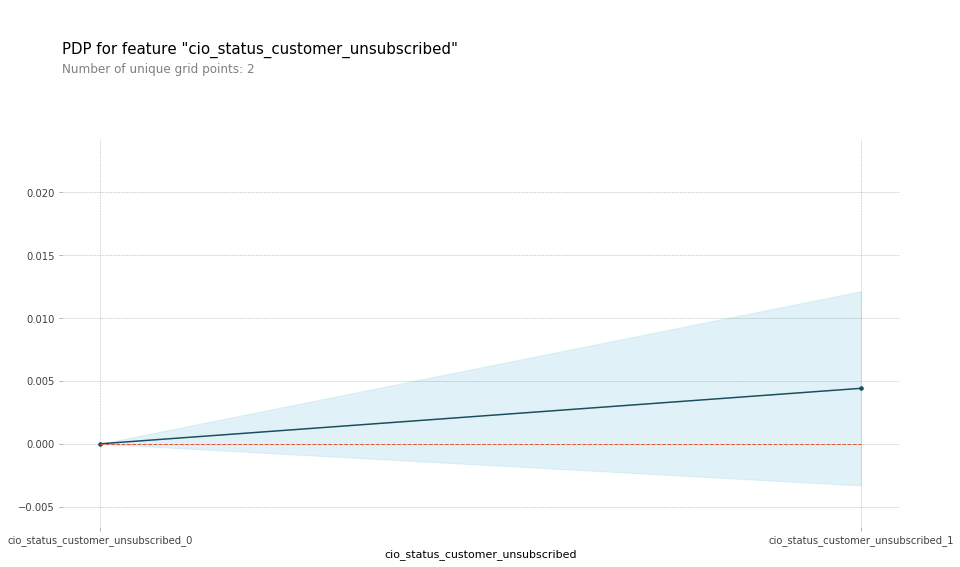

In [21]:
plot_pdp('cio_status_customer_unsubscribed');

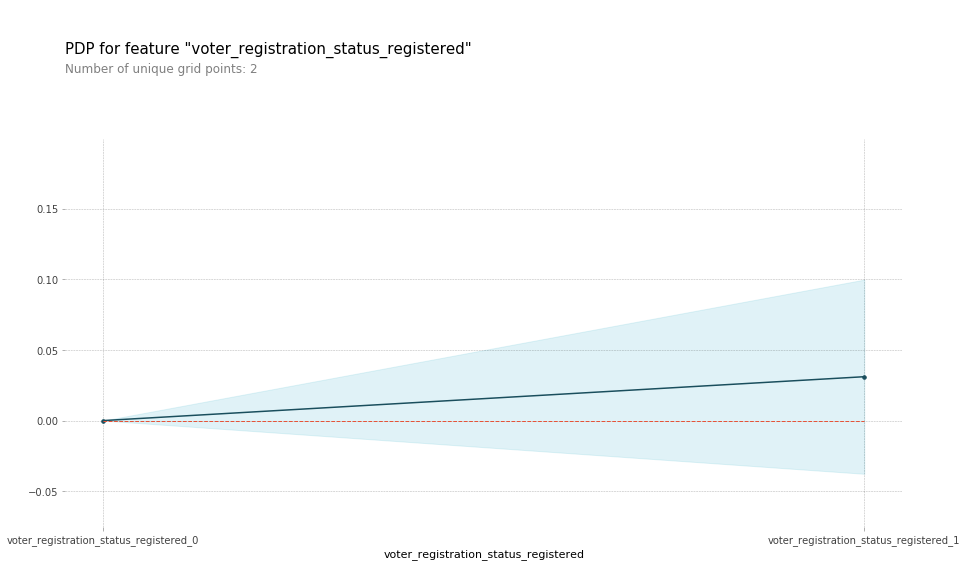

In [22]:
plot_pdp('voter_registration_status_registered');

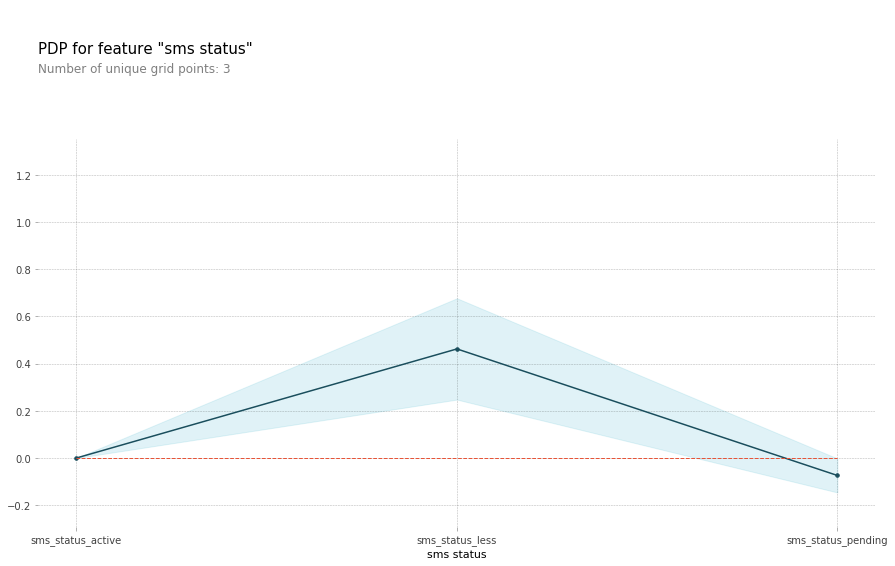

In [23]:
plot_pdp(feat=['sms_status_active', 'sms_status_less', 'sms_status_pending'], feat_name='sms status');

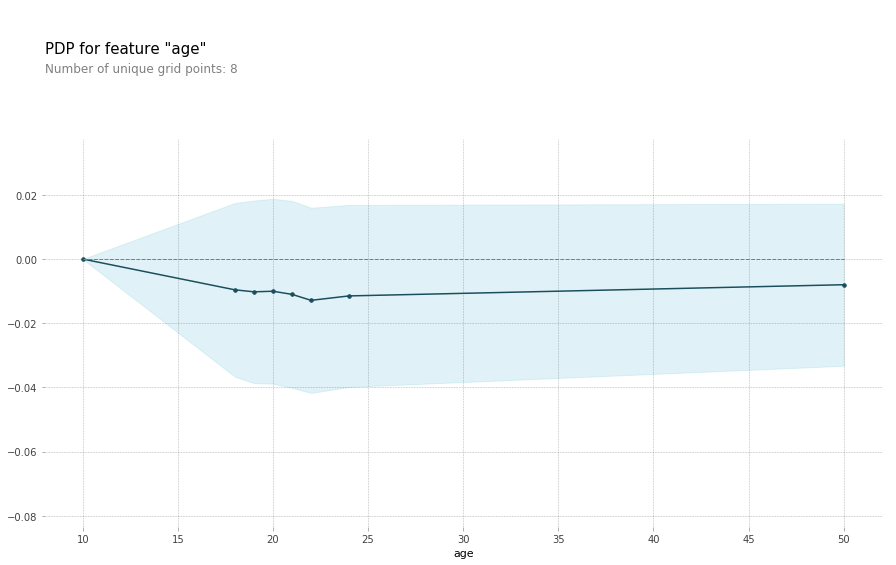

In [24]:
plot_pdp('age');